In [1]:
import iss_patcher as ip
import scanpy as sc
import anndata as ad

sc.settings.set_figure_params(dpi=80)

Load example data. Both objects have raw counts in `.X`.

**TODO: put this up on FTP once this goes public, can point `backup_url` to an FTP link**

In [2]:
iss = sc.read("/lustre/scratch126/cellgen/team205/lf15/bone1/ISS/iss-patcher/ISS_RNA_rawcounts.h5ad")
gex = sc.read("/lustre/scratch126/cellgen/team205/lf15/bone1/ISS/ISS_website_v1/imputed/data/Shoulder_73pcw_referenceRNA_rawcount.h5ad")

The ISS data is low-dimensional, with few features captured experimentally.

In [3]:
iss

AnnData object with n_obs × n_vars = 40587 × 155
    obs: 'sample', 'total_counts', 'n_genes_by_counts', 'leiden', 'n_genes'
    var: 'total_counts', 'n_cells_by_counts'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

The GEX data has more features as it's transcriptomics.

In [4]:
gex

AnnData object with n_obs × n_vars = 5252 × 33958
    obs: 'nCount_RNA', 'nFeature_RNA', 'run_id', 'batch', 'relative_position', 'bone', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'anatomical_site', 'pcw', 'brc_code', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'G2M_score', 'S_score', '_scvi_batch', '_scvi_labels', 'annot', 'broad_annot', 'broad_annot_v2', 'fig1_legend', 'finanno1', 'leiden_scVI', 'leiden_scVI_1.5', 'leiden_scVI_subcluster', 'phase'
    var: 'name-0', 'name-1', 'name-10', 'name-11', 'name-12', 'name-13', 'name-14', 'name-15', 'name-16', 'name-17', 'name-18', 'name-19', 'name-2', 'name-20', 'name-21', 'name-22', 'name-23', 'name-24', 'name-25', 'name-26', 'name-27', 'name-28', 'name-0-29', 'name-1-29', 'name-2-29', 'name-3-29', 'name-4-29', 'name-3', 'name-0-

All of the ISS genes are captured in the GEX.

In [5]:
len(set(iss.var_names).intersection(gex.var_names))

155

At this point we can run `ip.patch(iss, gex)`. The function will:
- split the high dimensionality `gex` into two sub-objects, one matching the feature space of `iss` and the other holding information for the features not appearing in `iss`.
- compute a z-score representation of the data in the two objects with the `iss` feature space (via the Scanpy standard of `normalize_total()` to per-dataset medians, into `log1p()` and `scale()`)
- identify each `iss` cell's neighbours in the feature space shared with `gex`
- compute the mean of features not appearing in `iss` for each `iss` cell's neighbour set
- optionally identify the most common metadata value of specified `obs_to_take` columns from `gex` and report that for each `iss` cell

In [6]:
out = ip.patch(iss=iss, gex=gex, obs_to_take="finanno1", neighbours=5)

/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


The resulting object has counts in `.X`, ready for subsequent processing. The feature space is the 33803 (33958 - 155) genes absent from the original ISS data. The `.obs` mostly come from the ISS object, and the `.var` come from the GEX object. `.obs['annot']` is generated based on the GEX neighbours, as requested in the function call. `obs['annot_fraction']` captures the fraction of the GEX neighbours that had the most common annotation. `.obsm` is copied from the ISS object.

In [7]:
out

AnnData object with n_obs × n_vars = 40587 × 33803
    obs: 'sample', 'total_counts', 'n_genes_by_counts', 'leiden', 'n_genes', 'finanno1', 'finanno1_fraction'
    var: 'name-0', 'name-1', 'name-10', 'name-11', 'name-12', 'name-13', 'name-14', 'name-15', 'name-16', 'name-17', 'name-18', 'name-19', 'name-2', 'name-20', 'name-21', 'name-22', 'name-23', 'name-24', 'name-25', 'name-26', 'name-27', 'name-28', 'name-0-29', 'name-1-29', 'name-2-29', 'name-3-29', 'name-4-29', 'name-3', 'name-0-30', 'name-1-30', 'name-2-30', 'name-3-30', 'name-4-30', 'name-0-31', 'name-1-31', 'name-2-31', 'name-3-31', 'name-4-31', 'name-0-32', 'name-1-32', 'name-2-32', 'name-3-32', 'name-4-32', 'name-0-33', 'name-1-33', 'name-2-33', 'name-3-33', 'name-4-33', 'name-34', 'name-35', 'name-36', 'name-37', 'name-38', 'name-39', 'name-4', 'name-40', 'name-0-41', 'name-1-41', 'name-2-41', 'name-3-41', 'name-0-42', 'name-1-42', 'name-2-42', 'name-3-42', 'name-0-43', 'name-1-43', 'name-2-43', 'name-3-43', 'name-0-44', '

Let's inspect some of the transferred annotations in the original spatial coordinates.

/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


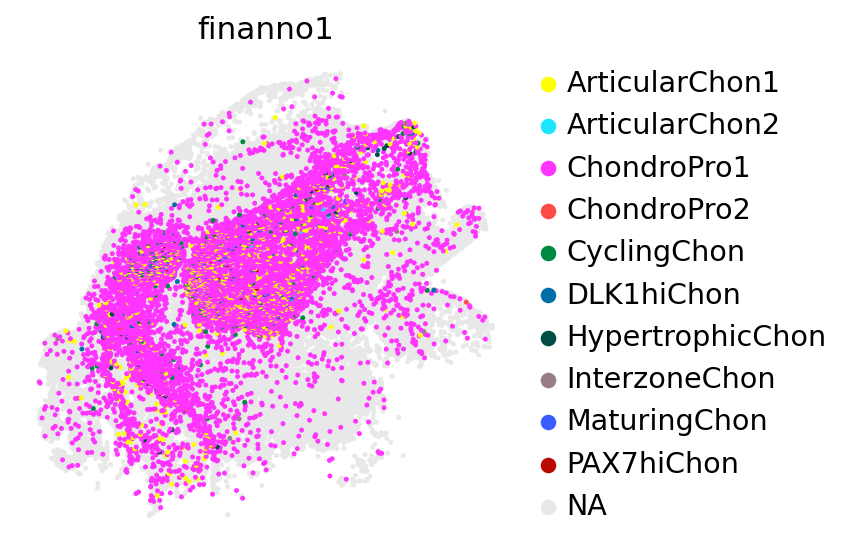

In [8]:
## all chondrocyte subtypes
order_celltypes= ['ArticularChon1','ArticularChon2',
                  'ChondroPro1','ChondroPro2',
                  'MaturingChon',
                  'CyclingChon','HypertrophicChon','InterzoneChon',
                  'DLK1hiChon','PAX7hiChon'
                 ]
sc.pl.embedding(out,basis='spatial',color='finanno1',groups=order_celltypes,size=20,frameon=False,na_color='#E8E8E8')

Visualise each population separately.

/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


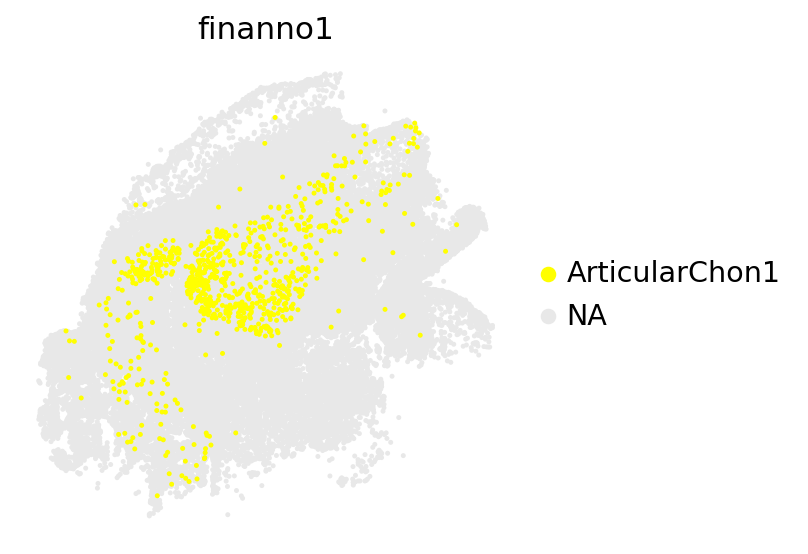

/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


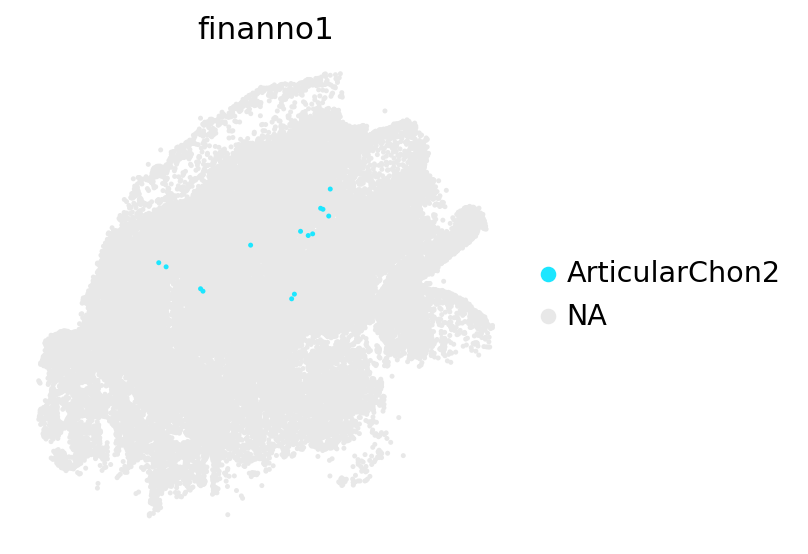

/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


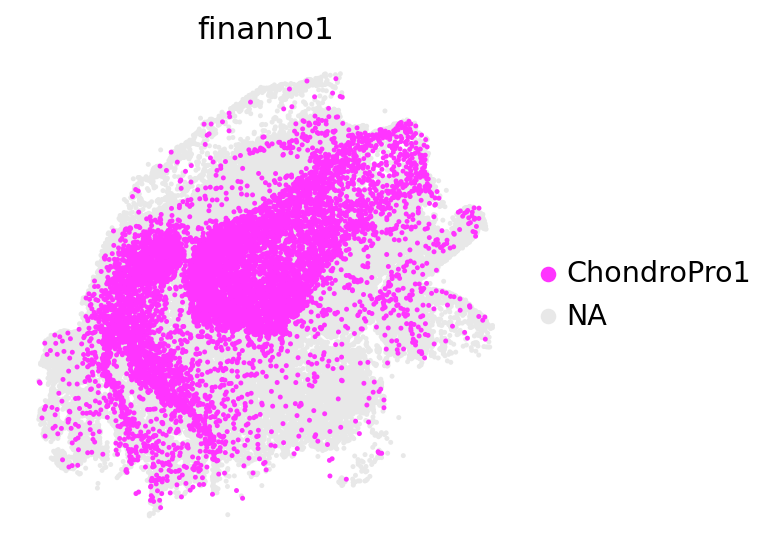

/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


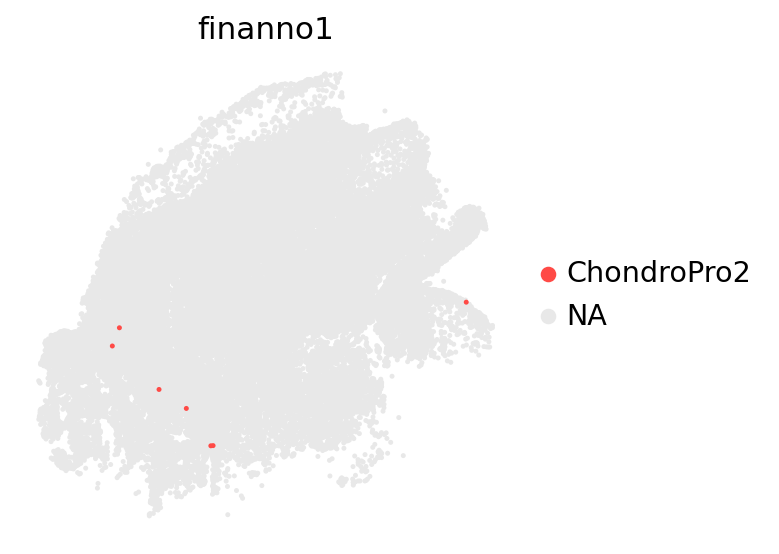

/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


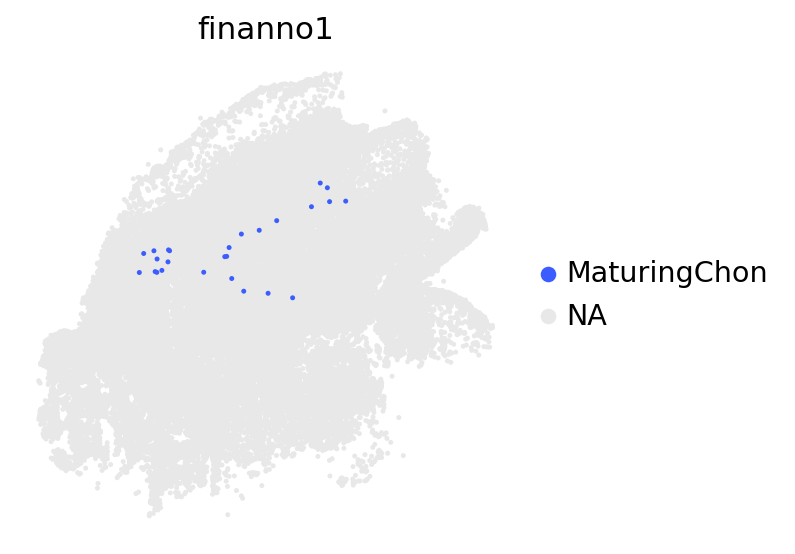

/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


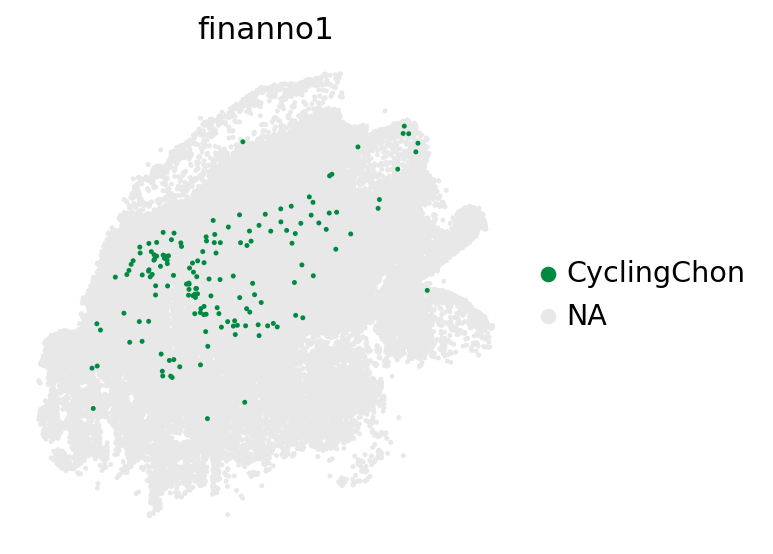

/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


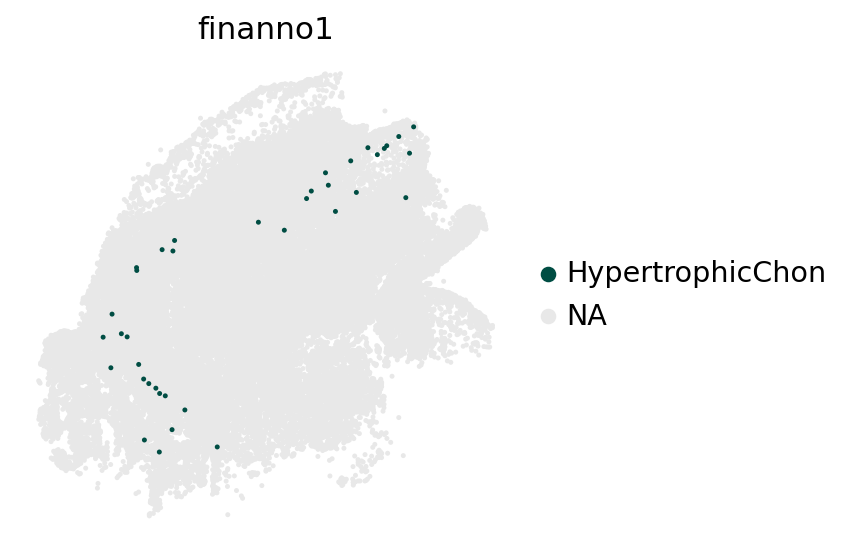

/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


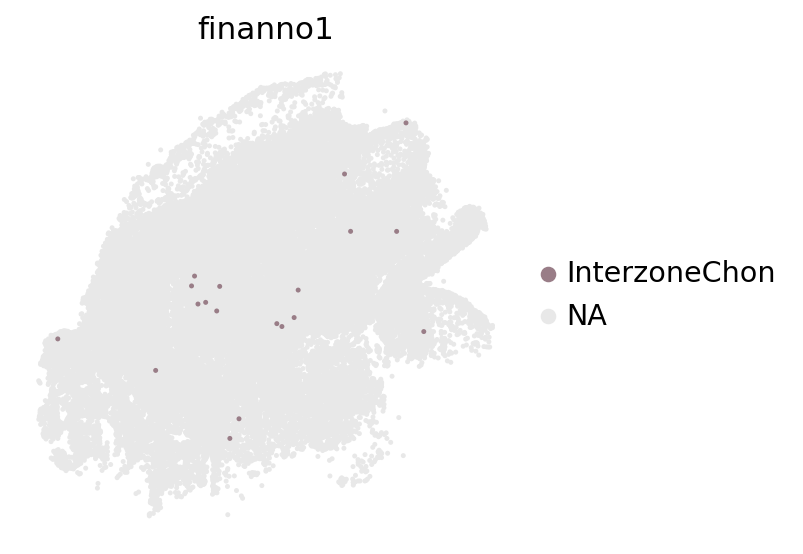

/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


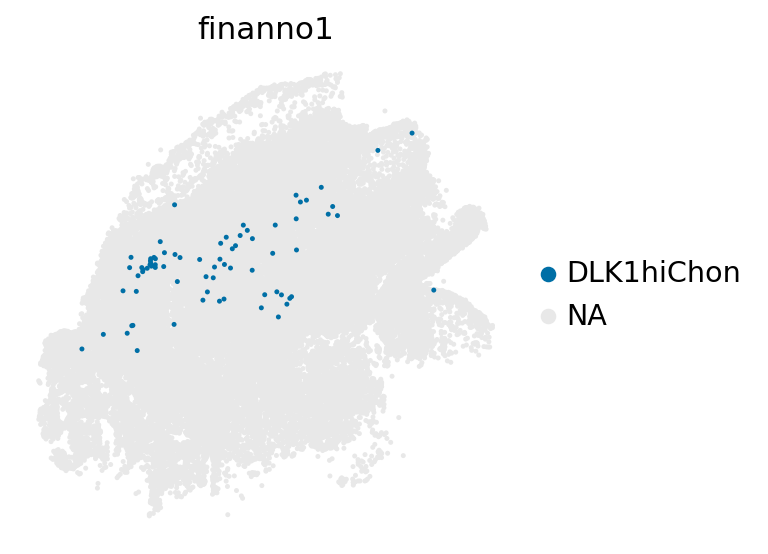

/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1227: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


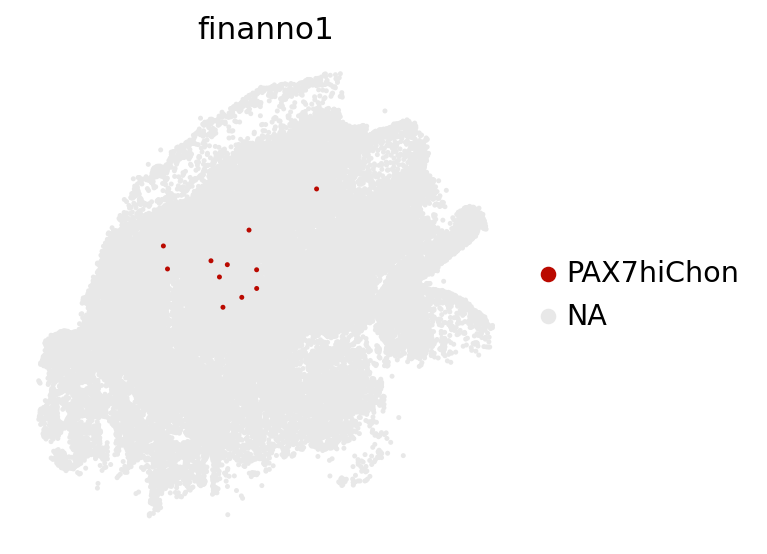

In [9]:
for i in order_celltypes:
    sc.pl.embedding(out,basis='spatial',color='finanno1',groups=i,size=20,frameon=False,na_color='#E8E8E8')

Inspect the total counts for each population.

<AxesSubplot: >

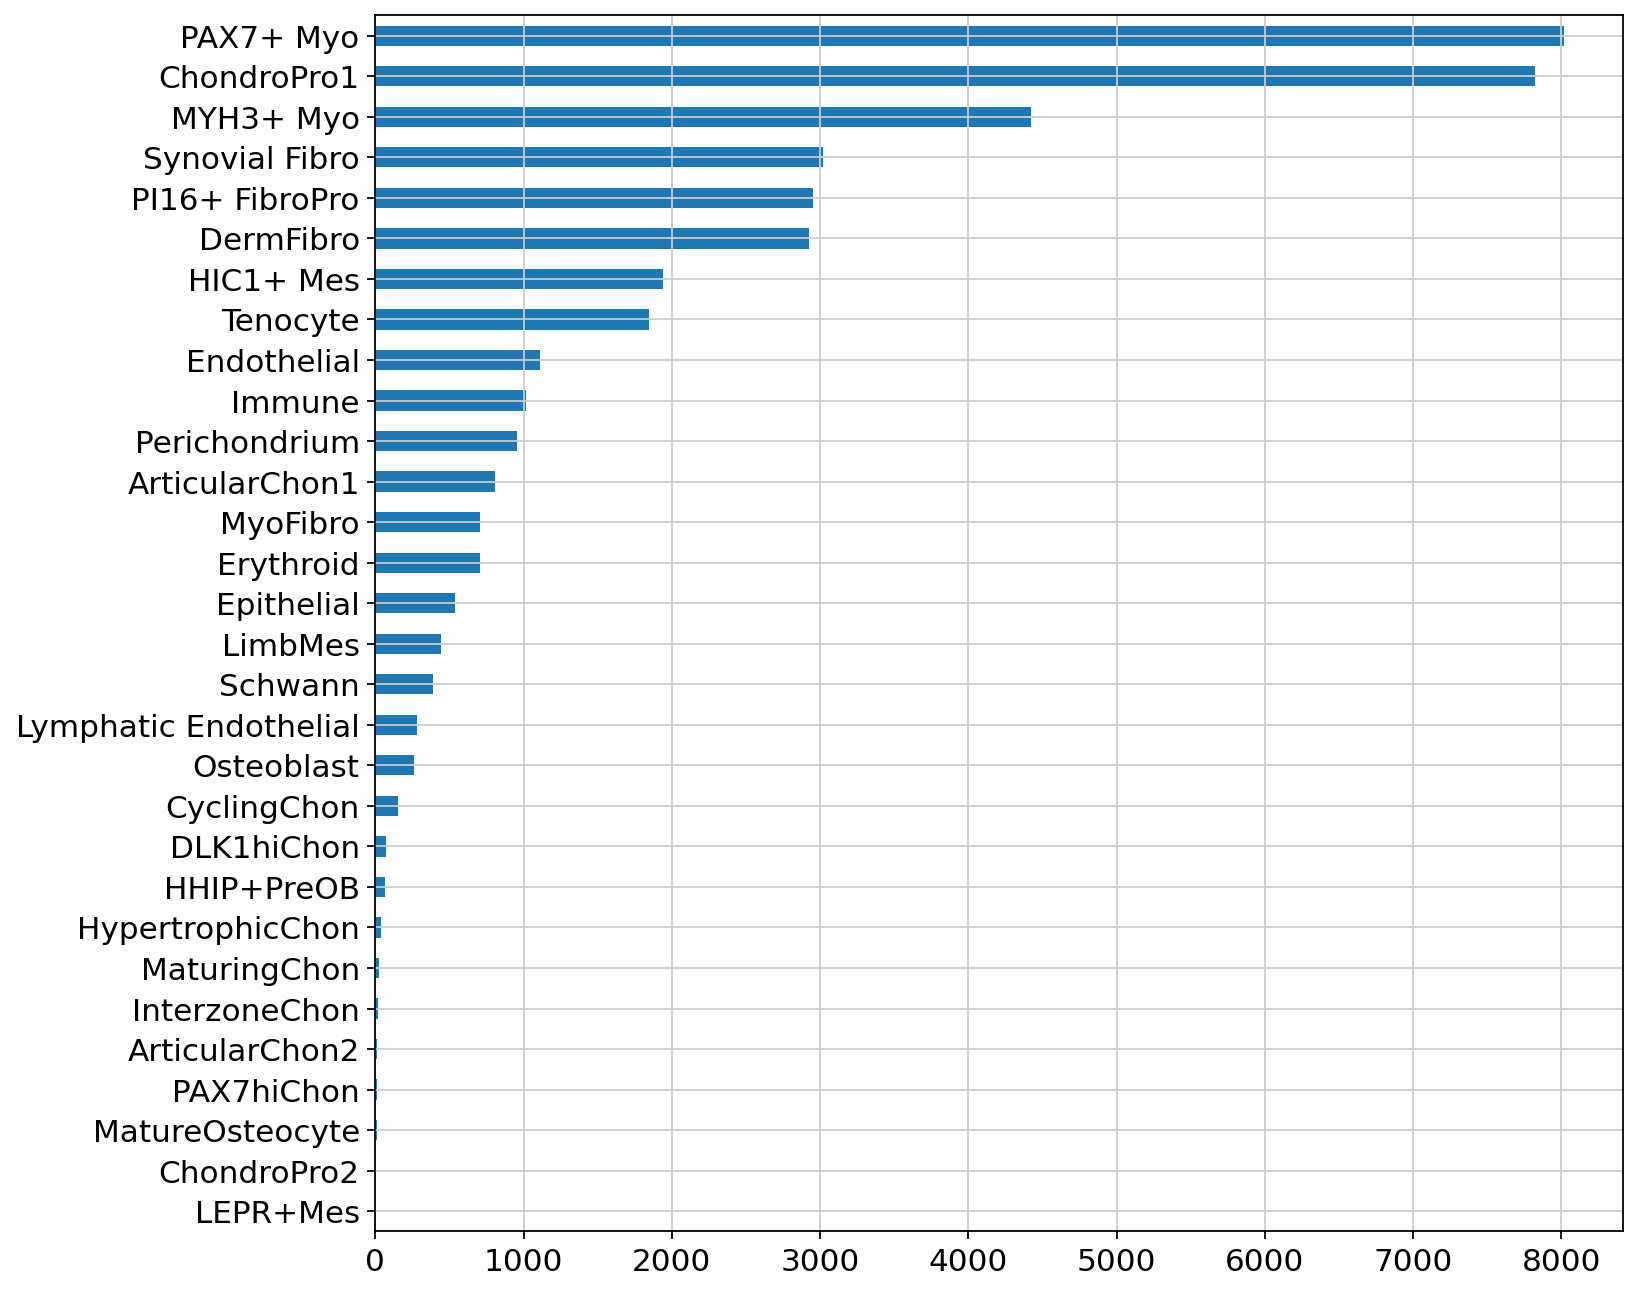

In [10]:
out.obs['finanno1'].value_counts().sort_values().plot(kind = 'barh', figsize=(10,10))